### "데이터 문화가 되다"  
2021(제2회) NH투자증권 빅데이터 경진대회 BASELINE

BASELINE을 통해 간단한 데이터 소개와 함께 힌트를 제공하려고 합니다.  
이번 대회는 stk_hld_train.csv 파일의 hold_d(보유일)를 Y값으로 모델을 학습시키고  
stk_hld_test.csv 파일의 hold_d(보유일)를 예측하는 과제를 풀어야 합니다.

### 라이브러리 불러오기

In [1]:
import pandas as pd
pd.set_option("display.max_row", 100)
pd.set_option("display.max_column", 100)
import numpy as np
import os

from sklearn.decomposition import PCA

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font',family='Malgun Gothic')
pd.set_option('display.max_columns', None)

### 데이터 불러오기

In [2]:
train = pd.read_csv('stk_hld_train.csv') # 국내주식 보유기간(train)
test = pd.read_csv('stk_hld_test.csv') #국내주식 보유기간(test)

hist = pd.read_csv('stk_bnc_hist.csv') #국내주식 잔고이력

cus = pd.read_csv('cus_info.csv') # 고객 정보 + 주거래계좌정보
iem = pd.read_csv('iem_info_20210902.csv') # 종목정보

submission = pd.read_csv('sample_submission.csv')

# 수집 데이터
krx = pd.read_csv('krx_clean_data.csv')

In [3]:
train.columns = ['계좌번호', '종목코드', '매수일', '보유일']
test.columns = ['계좌번호', '종목코드', '매수일', '이전주식보유기간', 'submit_id', '보유일']
hist.columns = ['계좌번호', '기준일자', '종목코드', '잔고수량', '잔고금액', '액면가']
cus.columns = ['계좌번호', '성별', '연령구간', '투자성향', '고객자산구간', '주거래상품군', 'lifestage', '고객등급', '총투자기간', '주거래업종구분']
iem.columns = ['종목코드', '종목한글명', '종목업종', '시가총액규모유형', '시장구분']

In [4]:
train.head() # stk_hld_train.csv

,계좌번호,종목코드,매수일,보유일
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A006360,20180726,11
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005930,20180131,80
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005070,20180517,5
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A003520,20201112,22
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A002310,20180905,324


In [5]:
test.head() # stk_hld_test.csv

,계좌번호,종목코드,매수일,이전주식보유기간,submit_id,보유일
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A032640,20200522,153,IDX00001,0
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A160600,20190823,335,IDX00002,0
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A234340,20200611,139,IDX00003,0
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A131760,20200120,236,IDX00004,0
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A293490,20201217,9,IDX00005,0


In [6]:
hist.head()

,계좌번호,기준일자,종목코드,잔고수량,잔고금액,액면가
0,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200820,A008770,40.0,2828000.0,5000.0
1,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200623,A008770,20.0,1390000.0,5000.0
2,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20160104,A005940,311.0,2982490.0,5000.0
3,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200814,A005930,40.0,2320000.0,100.0
4,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200623,A005930,20.0,1028000.0,100.0


In [7]:
cus.head()

,계좌번호,성별,연령구간,투자성향,고객자산구간,주거래상품군,lifestage,고객등급,총투자기간,주거래업종구분
0,64aae8dd71e5c0761000db9f9a6779e504e7a4aa9dc097...,1,4,99,1,2,3,3,6,16
1,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f...,1,6,4,4,2,5,2,6,1
2,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,2,7,4,3,2,5,5,6,9
3,6d497facfa1ea5901b827335553331f8555fec02a8184f...,2,6,4,4,8,5,3,6,16
4,b727c78d2cfc246c97b677f29a034399a0c7e7873fff44...,1,5,2,2,2,5,5,5,16


In [8]:
iem.head()

,종목코드,종목한글명,종목업종,시가총액규모유형,시장구분
0,A000020,동화약품,8,2,99
1,A000080,하이트진로,14,2,1
2,A000180,성창기업지주,5,3,99
3,A000227,유유제약2우B,8,99,99
4,A000325,노루홀딩스우,2,99,99


In [9]:
krx.head()

,날짜,시가,고가,저가,종가,거래량,등락률,종목코드
0,2016-01-04,8130,8150,7920,8140,281440,0.000000,A000020
1,2016-01-05,8040,8250,8000,8190,243179,0.006143,A000020
2,2016-01-06,8200,8590,8110,8550,609906,0.043956,A000020
3,2016-01-07,8470,8690,8190,8380,704752,-0.019883,A000020
4,2016-01-08,8210,8900,8130,8770,802330,0.046539,A000020


이미 눈치채신 분들도 있겠지만 stk_hld_test 데이터에는 stk_hld_train 데이터에 없는 column이 있습니다.  
바로 "hist_d"(이전주식보유기간) column입니다. "hist_d"는 stk_hld_test 데이터에 속한 고객이 2021년 이전에 주식을 보유한 기간입니다.

*Hint
Hold_d(보유기간) – hist_d(‘20년 12월 31일까지의 최근 보유기간) ≤ 146

2021년 데이터 기간은 ‘21년 1월 1일 ~ ‘21년 7월 31일로 제한했습니다.

따라서 학습 데이터 셋에서 다양한 기준으로 hist_d column을 만들어 새로운 feature로 사용해 보시는 것을 추천드립니다.

추가적으로 새로운 feature로 사용할 수 있는 정보에는 고객의 이전 주식 보유이력이 있습니다.(past_d로 칭하겠습니다.)  
  
stk_bnc_hist.csv 데이터를 살펴보면 stk_hld_test.csv 고객들의 이전 주식 보유이력(past_d)을 확인할 수 있습니다.  
  
stk_hld_train.csv도 마찬가지로 past_d column을 만들 수 있을 것으로 보입니다.

## 데이터 전처리

In [10]:
# 앞서 언급한 것처럼 베이스라인에서는 "hist_d" column을 임의로 생성하여 모델을 학습시키도록 하겠습니다.
# 베이스라인에서는 "hold_d"값, 즉 주식 보유기간의 0.6배에 해당하는 기간을 임의로 설정하여 "hist_d"를 생성하였습니다.
# 결국 모델은 "hist_d"만큼 주식을 보유 했을때의 "hold_d"를 예측하게 될 것입니다.

#train["이전주식보유기간"] = train["보유일"]*0.7
#train.이전주식보유기간 = np.trunc(train["이전주식보유기간"]) #소수점아래를 버림.

# 새로운 '이전주식보유기간'을 만들어야한다.

### hist 데이터 전처리 & merge

In [11]:
hist.head()
# 이전 주식 보유이력(past_d) 어떻게 만들까?

,계좌번호,기준일자,종목코드,잔고수량,잔고금액,액면가
0,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200820,A008770,40.0,2828000.0,5000.0
1,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200623,A008770,20.0,1390000.0,5000.0
2,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20160104,A005940,311.0,2982490.0,5000.0
3,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200814,A005930,40.0,2320000.0,100.0
4,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200623,A005930,20.0,1028000.0,100.0


In [12]:
train_data = pd.merge(train, hist, how = "left", on = ["계좌번호", "종목코드"])
train_data = train_data[(train_data["매수일"] == train_data["기준일자"])]

test_data = pd.merge(test, hist, how = "left", on = ["계좌번호", "종목코드"])
test_data = test_data[(test_data["매수일"] == test_data["기준일자"])]

### cus 데이터 전처리 & merge

In [13]:
cus.head()

,계좌번호,성별,연령구간,투자성향,고객자산구간,주거래상품군,lifestage,고객등급,총투자기간,주거래업종구분
0,64aae8dd71e5c0761000db9f9a6779e504e7a4aa9dc097...,1,4,99,1,2,3,3,6,16
1,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f...,1,6,4,4,2,5,2,6,1
2,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,2,7,4,3,2,5,5,6,9
3,6d497facfa1ea5901b827335553331f8555fec02a8184f...,2,6,4,4,8,5,3,6,16
4,b727c78d2cfc246c97b677f29a034399a0c7e7873fff44...,1,5,2,2,2,5,5,5,16


In [14]:
train_data = pd.merge(train_data, cus, how = "left", on = ["계좌번호"])
test_data = pd.merge(test_data, cus, how = "left", on = ["계좌번호"])

### iem 데이터 전처리 & merge

In [15]:
iem.head()

,종목코드,종목한글명,종목업종,시가총액규모유형,시장구분
0,A000020,동화약품,8,2,99
1,A000080,하이트진로,14,2,1
2,A000180,성창기업지주,5,3,99
3,A000227,유유제약2우B,8,99,99
4,A000325,노루홀딩스우,2,99,99


In [16]:
train_data = pd.merge(train_data, iem, how = "left", on = ["종목코드"])
test_data = pd.merge(test_data, iem, how = "left", on = ["종목코드"])

## Feature Engineering

In [17]:
train_data.columns

Index(['계좌번호', '종목코드', '매수일', '보유일', '기준일자', '잔고수량', '잔고금액', '액면가', '성별',
       '연령구간', '투자성향', '고객자산구간', '주거래상품군', 'lifestage', '고객등급', '총투자기간',
       '주거래업종구분', '종목한글명', '종목업종', '시가총액규모유형', '시장구분'],
      dtype='object')

## Numeric

In [18]:
# 1. 투자종목개수
f = train_data.groupby('계좌번호')['종목코드'].agg([('투자종목개수',lambda x: x.nunique())]).reset_index()
train_data = pd.merge(train_data, f, on = '계좌번호')

In [19]:
f_te = test_data.groupby('계좌번호')['종목코드'].agg([('투자종목개수',lambda x: x.nunique())]).reset_index()
test_data = pd.merge(test_data, f_te, on = '계좌번호')

In [20]:
# 2. 투자비율
train_data['투자비율']=train_data['투자종목개수']/train_data.종목코드.nunique()
test_data['투자비율']=test_data['투자종목개수']/test_data.종목코드.nunique()

In [21]:
# 3. 투자성향*투자종목개수 / 성격유형에 따른 주식투자행동에 관현연구 (조국행,이지은) 유의확률 0.017로 상관관계있음.
train_data['투자성향_투자종목개수']=train_data['투자성향']*train_data['투자종목개수']
test_data['투자성향_투자종목개수']=test_data['투자성향']*test_data['투자종목개수']

In [22]:
# 4. 총매수횟수
f = train_data.groupby('계좌번호')['매수일'].agg([('총매수횟수', 'count')]).reset_index()
train_data = pd.merge(train_data, f, on = '계좌번호')

In [23]:
f_te = test_data.groupby('계좌번호')['매수일'].agg([('총매수횟수', 'count')]).reset_index()
test_data = pd.merge(test_data, f_te, on = '계좌번호')

In [24]:
# 5. 총잔고수량
f = train_data.groupby(['계좌번호'])['잔고수량'].agg([('총잔고수량','sum')])
train_data = pd.merge(train_data, f, on='계좌번호')

In [25]:
f_te = test_data.groupby(['계좌번호'])['잔고수량'].agg([('총잔고수량','sum')])
test_data = pd.merge(test_data, f_te, on = '계좌번호')

In [26]:
# 6. 총잔고금액
f = train_data.groupby(['계좌번호'])['잔고금액'].agg([('총잔고금액','sum')])
train_data = pd.merge(train_data, f, on='계좌번호')

In [27]:
f_te = test_data.groupby(['계좌번호'])['잔고금액'].agg([('총잔고금액','sum')])
test_data = pd.merge(test_data, f_te, on='계좌번호')

In [28]:
# 7. 평균잔고금액
f = train_data.groupby(['계좌번호'])['잔고금액'].agg([('평균잔고금액','mean')])
train_data = pd.merge(train_data, f, on='계좌번호')

In [29]:
f_te = test_data.groupby(['계좌번호'])['잔고금액'].agg([('평균잔고금액','mean')])
test_data = pd.merge(test_data, f_te, on='계좌번호')

In [30]:
# 8. 잔고수량당 잔고금액
train_data["잔고수량당 잔고금액"] = train_data["잔고금액"] / train_data["잔고수량"]
test_data["잔고수량당 잔고금액"] = test_data["잔고금액"] / test_data["잔고수량"]

In [31]:
# 9. 보유금액
train_data['보유금액'] = train_data['잔고수량']*train_data['액면가']
test_data['보유금액'] = test_data['잔고수량']*test_data['액면가']

In [32]:
# 10. 총보유금액
f = train_data.groupby(['계좌번호'])['보유금액'].agg([('총보유금액','sum')])
train_data = pd.merge(train_data, f, on='계좌번호')

In [33]:
f_te = test_data.groupby(['계좌번호'])['보유금액'].agg([('총보유금액','sum')])
test_data = pd.merge(test_data, f_te, on='계좌번호')

In [34]:
# 11. 평균보유금액
f = train_data.groupby(['계좌번호'])['보유금액'].agg([('평균보유금액','mean')])
train_data = pd.merge(train_data, f, on='계좌번호')

In [35]:
f_te = test_data.groupby(['계좌번호'])['보유금액'].agg([('평균보유금액','mean')])
test_data = pd.merge(test_data, f_te, on='계좌번호')

In [36]:
# 12. 보유금액당 잔고금액
train_data['보유금액당 잔고금액'] = train_data['잔고금액'] / train_data['보유금액']
test_data['보유금액당 잔고금액'] = test_data['잔고금액'] / test_data['보유금액']

## Category

In [37]:
cus.head()

,계좌번호,성별,연령구간,투자성향,고객자산구간,주거래상품군,lifestage,고객등급,총투자기간,주거래업종구분
0,64aae8dd71e5c0761000db9f9a6779e504e7a4aa9dc097...,1,4,99,1,2,3,3,6,16
1,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f...,1,6,4,4,2,5,2,6,1
2,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,2,7,4,3,2,5,5,6,9
3,6d497facfa1ea5901b827335553331f8555fec02a8184f...,2,6,4,4,8,5,3,6,16
4,b727c78d2cfc246c97b677f29a034399a0c7e7873fff44...,1,5,2,2,2,5,5,5,16


In [38]:
iem.head()

,종목코드,종목한글명,종목업종,시가총액규모유형,시장구분
0,A000020,동화약품,8,2,99
1,A000080,하이트진로,14,2,1
2,A000180,성창기업지주,5,3,99
3,A000227,유유제약2우B,8,99,99
4,A000325,노루홀딩스우,2,99,99


In [39]:
# 13. 종목업종별 매수횟수
f = train_data.groupby('계좌번호')['종목업종'].value_counts().unstack().fillna(0)
f.columns = [str(column) + '_종목업종 매수횟수' for column in f.columns]
f = f.reset_index()
train_data = pd.merge(train_data, f, on='계좌번호'); f

,계좌번호,1_종목업종 매수횟수,2_종목업종 매수횟수,3_종목업종 매수횟수,4_종목업종 매수횟수,5_종목업종 매수횟수,6_종목업종 매수횟수,7_종목업종 매수횟수,8_종목업종 매수횟수,9_종목업종 매수횟수,10_종목업종 매수횟수,11_종목업종 매수횟수,12_종목업종 매수횟수,13_종목업종 매수횟수,14_종목업종 매수횟수
0,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,0.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,7.0,0.0,4.0,6.0,1.0
1,0007f3d10282e6f9de1eb445a64eb1f13e9ed2308cfbfa...,0.0,2.0,2.0,0.0,7.0,0.0,1.0,5.0,3.0,7.0,0.0,0.0,5.0,0.0
2,0008d1bfac569bdb998897e2eb8519dec06b9277a686f4...,1.0,3.0,0.0,0.0,6.0,1.0,2.0,1.0,1.0,19.0,0.0,2.0,16.0,2.0
3,000a83a961cbcbce40673aed998effbd462fb10dcac8e6...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,000b92ca83a96312a0909b1f489340f4d399c86555012f...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9332,ffdccfb9dc24cf41843f6e7f34704ccb73ac81acc29aa3...,7.0,35.0,12.0,4.0,106.0,30.0,47.0,56.0,14.0,272.0,10.0,14.0,134.0,35.0
9333,ffecc8e2823943ef1a7b0d9c6512f716a88032a1bdf7ba...,0.0,1.0,0.0,1.0,6.0,2.0,4.0,6.0,5.0,20.0,0.0,0.0,8.0,2.0
9334,ffee399294db1c721e010cbf3dae5c8a1f140dbaf2dcae...,0.0,0.0,0.0,0.0,5.0,2.0,2.0,1.0,2.0,4.0,0.0,2.0,1.0,1.0
9335,fff7d563e388744fdc1ca90153ec0161d1345511cb9070...,0.0,0.0,1.0,0.0,1.0,0.0,3.0,3.0,4.0,11.0,0.0,2.0,1.0,2.0


In [40]:
f_te = test_data.groupby('계좌번호')['종목업종'].value_counts().unstack().fillna(0)
f_te.columns = [str(column) + '_종목업종 매수횟수' for column in f_te.columns]
f_te = f_te.reset_index()
test_data = pd.merge(test_data, f_te, on='계좌번호'); f_te

,계좌번호,1_종목업종 매수횟수,2_종목업종 매수횟수,3_종목업종 매수횟수,4_종목업종 매수횟수,5_종목업종 매수횟수,6_종목업종 매수횟수,7_종목업종 매수횟수,8_종목업종 매수횟수,9_종목업종 매수횟수,10_종목업종 매수횟수,11_종목업종 매수횟수,12_종목업종 매수횟수,13_종목업종 매수횟수,14_종목업종 매수횟수
0,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0
1,0007f3d10282e6f9de1eb445a64eb1f13e9ed2308cfbfa...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0
2,0008d1bfac569bdb998897e2eb8519dec06b9277a686f4...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0
3,000a83a961cbcbce40673aed998effbd462fb10dcac8e6...,0.0,1.0,1.0,0.0,3.0,0.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,1.0
4,000b92ca83a96312a0909b1f489340f4d399c86555012f...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9975,ffea89aa464a4fcf8a5416989d21deef4e748192ba17bf...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0
9976,ffecc8e2823943ef1a7b0d9c6512f716a88032a1bdf7ba...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9977,ffee399294db1c721e010cbf3dae5c8a1f140dbaf2dcae...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
9978,fff7d563e388744fdc1ca90153ec0161d1345511cb9070...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [41]:
# 14. 종목업종별 매수비율
for i in range(1,15):
    train_data[str(i)+'_종목업종 매수비율']=train_data[str(i)+'_종목업종 매수횟수']/train_data['총매수횟수']
    
    test_data[str(i)+'_종목업종 매수비율']=test_data[str(i)+'_종목업종 매수횟수']/test_data['총매수횟수']

In [42]:
# 15. 시가총액규모유형별 매수횟수
f = train_data.groupby('계좌번호')['시가총액규모유형'].value_counts().unstack().fillna(0)
f.columns = [str(column)+'_시가총액규모유형 매수횟수' for column in f.columns]
f = f.reset_index()
train_data = pd.merge(train_data, f, on='계좌번호'); f

,계좌번호,1_시가총액규모유형 매수횟수,2_시가총액규모유형 매수횟수,3_시가총액규모유형 매수횟수,99_시가총액규모유형 매수횟수
0,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,3.0,8.0,12.0,0.0
1,0007f3d10282e6f9de1eb445a64eb1f13e9ed2308cfbfa...,14.0,11.0,7.0,0.0
2,0008d1bfac569bdb998897e2eb8519dec06b9277a686f4...,14.0,15.0,25.0,0.0
3,000a83a961cbcbce40673aed998effbd462fb10dcac8e6...,2.0,1.0,0.0,0.0
4,000b92ca83a96312a0909b1f489340f4d399c86555012f...,3.0,0.0,0.0,0.0
...,...,...,...,...,...
9332,ffdccfb9dc24cf41843f6e7f34704ccb73ac81acc29aa3...,107.0,222.0,415.0,32.0
9333,ffecc8e2823943ef1a7b0d9c6512f716a88032a1bdf7ba...,10.0,24.0,19.0,2.0
9334,ffee399294db1c721e010cbf3dae5c8a1f140dbaf2dcae...,12.0,3.0,5.0,0.0
9335,fff7d563e388744fdc1ca90153ec0161d1345511cb9070...,4.0,8.0,11.0,5.0


In [43]:
f_te = test_data.groupby('계좌번호')['시가총액규모유형'].value_counts().unstack().fillna(0)
f_te.columns = [str(column)+'_시가총액규모유형 매수횟수' for column in f_te.columns]
f_te = f_te.reset_index()
test_data = pd.merge(test_data, f_te, on='계좌번호'); f_te

,계좌번호,1_시가총액규모유형 매수횟수,2_시가총액규모유형 매수횟수,3_시가총액규모유형 매수횟수,99_시가총액규모유형 매수횟수
0,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,2.0,1.0,0.0,1.0
1,0007f3d10282e6f9de1eb445a64eb1f13e9ed2308cfbfa...,1.0,2.0,4.0,2.0
2,0008d1bfac569bdb998897e2eb8519dec06b9277a686f4...,1.0,2.0,1.0,0.0
3,000a83a961cbcbce40673aed998effbd462fb10dcac8e6...,8.0,1.0,2.0,0.0
4,000b92ca83a96312a0909b1f489340f4d399c86555012f...,0.0,0.0,0.0,3.0
...,...,...,...,...,...
9975,ffea89aa464a4fcf8a5416989d21deef4e748192ba17bf...,2.0,1.0,2.0,0.0
9976,ffecc8e2823943ef1a7b0d9c6512f716a88032a1bdf7ba...,0.0,1.0,0.0,0.0
9977,ffee399294db1c721e010cbf3dae5c8a1f140dbaf2dcae...,4.0,3.0,2.0,0.0
9978,fff7d563e388744fdc1ca90153ec0161d1345511cb9070...,0.0,0.0,4.0,1.0


In [44]:
# 16. 시가총액규모유형별 매수비율
for i in [1, 2, 3, 99]:
    train_data[str(i)+'_시가총액규모유형 매수비율']=train_data[str(i)+'_시가총액규모유형 매수횟수']/train_data['총매수횟수']
    
    test_data[str(i)+'_시가총액규모유형 매수비율']=test_data[str(i)+'_시가총액규모유형 매수횟수']/test_data['총매수횟수']

In [45]:
# 17. 시장구분별 매수횟수
f = train_data.groupby('계좌번호')['시장구분'].value_counts().unstack().fillna(0)
f.columns = [str(column)+'_시장구분 매수횟수' for column in f.columns]
f = f.reset_index()
train_data = pd.merge(train_data, f, on='계좌번호'); f

,계좌번호,1_시장구분 매수횟수,2_시장구분 매수횟수,99_시장구분 매수횟수
0,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,3.0,3.0,17.0
1,0007f3d10282e6f9de1eb445a64eb1f13e9ed2308cfbfa...,9.0,7.0,16.0
2,0008d1bfac569bdb998897e2eb8519dec06b9277a686f4...,8.0,9.0,37.0
3,000a83a961cbcbce40673aed998effbd462fb10dcac8e6...,3.0,0.0,0.0
4,000b92ca83a96312a0909b1f489340f4d399c86555012f...,3.0,0.0,0.0
...,...,...,...,...
9332,ffdccfb9dc24cf41843f6e7f34704ccb73ac81acc29aa3...,55.0,116.0,605.0
9333,ffecc8e2823943ef1a7b0d9c6512f716a88032a1bdf7ba...,5.0,12.0,38.0
9334,ffee399294db1c721e010cbf3dae5c8a1f140dbaf2dcae...,9.0,6.0,5.0
9335,fff7d563e388744fdc1ca90153ec0161d1345511cb9070...,3.0,4.0,21.0


In [46]:
f_te = test_data.groupby('계좌번호')['시장구분'].value_counts().unstack().fillna(0)
f_te.columns = [str(column)+'_시장구분 매수횟수' for column in f_te.columns]
f_te = f_te.reset_index()
test_data = pd.merge(test_data, f_te, on='계좌번호'); f_te

,계좌번호,1_시장구분 매수횟수,2_시장구분 매수횟수,99_시장구분 매수횟수
0,0000c7a5a5a1db9c7e890da984b20d544c09cb6f51c546...,1.0,2.0,1.0
1,0007f3d10282e6f9de1eb445a64eb1f13e9ed2308cfbfa...,2.0,0.0,7.0
2,0008d1bfac569bdb998897e2eb8519dec06b9277a686f4...,0.0,1.0,3.0
3,000a83a961cbcbce40673aed998effbd462fb10dcac8e6...,9.0,0.0,2.0
4,000b92ca83a96312a0909b1f489340f4d399c86555012f...,0.0,0.0,3.0
...,...,...,...,...
9975,ffea89aa464a4fcf8a5416989d21deef4e748192ba17bf...,2.0,0.0,3.0
9976,ffecc8e2823943ef1a7b0d9c6512f716a88032a1bdf7ba...,0.0,0.0,1.0
9977,ffee399294db1c721e010cbf3dae5c8a1f140dbaf2dcae...,4.0,1.0,4.0
9978,fff7d563e388744fdc1ca90153ec0161d1345511cb9070...,0.0,0.0,5.0


In [47]:
# 18. 시장구분별 매수비율
for i in [1, 2, 99]:
    train_data[str(i)+'_시장구분 매수비율']=train_data[str(i)+'_시장구분 매수횟수']/train_data['총매수횟수']
    
    test_data[str(i)+'_시장구분 매수비율']=test_data[str(i)+'_시장구분 매수횟수']/test_data['총매수횟수']

In [48]:
# cus data - one hot encoding + PCA
cus = cus.astype('object')
ohe_cus = pd.get_dummies(cus.iloc[:,1:])
pca = PCA(n_components=0.8).fit(ohe_cus) 
ohe_cus = pca.transform(ohe_cus)
ohe_cus = pd.DataFrame(ohe_cus)
ohe_cus.columns = ['ohe_cus_'+ str(column) for column in ohe_cus.columns]

ohe_cus.index = cus.계좌번호.unique()
ohe_cus = ohe_cus.reset_index()
ohe_cus.rename(columns={'index':'계좌번호'}, inplace=True)
ohe_cus.head()

,계좌번호,ohe_cus_0,ohe_cus_1,ohe_cus_2,ohe_cus_3,ohe_cus_4,ohe_cus_5,ohe_cus_6,ohe_cus_7,ohe_cus_8,ohe_cus_9,ohe_cus_10,ohe_cus_11,ohe_cus_12,ohe_cus_13,ohe_cus_14,ohe_cus_15,ohe_cus_16,ohe_cus_17,ohe_cus_18,ohe_cus_19,ohe_cus_20,ohe_cus_21
0,64aae8dd71e5c0761000db9f9a6779e504e7a4aa9dc097...,-0.085477,0.911694,-0.201933,-0.135271,-0.061101,-1.115059,0.272249,0.863430,-0.372220,0.104892,-0.527682,0.294076,-0.015587,0.338102,-0.093197,-0.293431,0.127327,0.032614,-0.371866,-0.126524,0.385175,-0.197612
1,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f...,-0.895421,0.147012,-0.494586,0.677410,0.101848,0.318660,-0.532954,-0.086384,-0.359518,-0.672727,0.060177,0.075132,-0.033776,-0.218050,0.811434,-0.137016,-0.447644,-0.200433,0.167749,0.004493,0.510050,-0.050884
2,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,-0.085826,-1.043434,-0.085485,0.309364,0.114436,0.277455,-0.696777,-0.197046,-0.412978,-0.701778,0.507931,0.294639,-0.052088,-0.319028,0.131620,-0.265091,1.023626,1.048349,-0.322063,0.110229,0.350712,0.312213
3,6d497facfa1ea5901b827335553331f8555fec02a8184f...,-0.084037,-0.758291,-0.848487,0.572151,-0.054382,0.252302,-0.681035,0.288775,-0.950997,-0.448946,-0.506668,-0.052488,0.220364,-0.237095,0.519028,-0.470430,-0.692487,-0.170451,-0.405864,-0.048967,0.666372,-0.219926
4,b727c78d2cfc246c97b677f29a034399a0c7e7873fff44...,-0.793710,-0.167809,0.553068,0.059580,1.042632,0.075684,-0.581589,-0.471497,-0.707523,0.103764,-0.068382,0.298195,0.718892,0.779780,-0.619754,-0.013910,-0.071410,-0.176877,-0.247312,0.075959,0.052691,-0.356199


In [49]:
train_data = pd.merge(train_data, ohe_cus, how = "left", on = ["계좌번호"])
test_data = pd.merge(test_data, ohe_cus, how = "left", on = ["계좌번호"])

In [50]:
# iem data - one hot encoding + PCA
iem = iem.astype('object')
ohe_iem = pd.get_dummies(iem.iloc[:, 2:])
pca = PCA(n_components=0.8).fit(ohe_iem) 
ohe_iem = pca.transform(ohe_iem)
ohe_iem = pd.DataFrame(ohe_iem)
ohe_iem.columns = ['ohe_iem_'+ str(column) for column in ohe_iem.columns]

ohe_iem.index = iem.종목코드.unique()
ohe_iem = ohe_iem.reset_index()
ohe_iem.rename(columns={'index':'종목코드'}, inplace=True)
ohe_iem.head()

,종목코드,ohe_iem_0,ohe_iem_1,ohe_iem_2,ohe_iem_3,ohe_iem_4,ohe_iem_5,ohe_iem_6
0,A000020,0.098577,0.699998,0.046934,-0.660693,-0.409681,-0.048362,0.008707
1,A000080,0.673881,1.116037,-0.040394,0.091592,-0.324690,-0.715845,-0.776247
2,A000180,-0.526681,-0.227770,-0.243155,0.173168,-0.428561,-0.320978,0.771358
3,A000227,0.635715,-0.035343,0.014956,-0.044336,-0.044058,0.440553,0.279966
4,A000325,0.620821,-0.014101,-0.038615,0.016159,-0.281797,1.156651,0.207435


In [51]:
train_data = pd.merge(train_data, ohe_iem, how = "left", on = ["종목코드"])
test_data = pd.merge(test_data, ohe_iem, how = "left", on = ["종목코드"])

In [52]:
# L_encoder = LabelEncoder()
# L_encoder.fit(iem["종목한글명"])
# train_data["종목한글명"] = L_encoder.transform(train_data["종목한글명"])
# test_data["종목한글명"] = L_encoder.transform(test_data["종목한글명"])

### [수집데이터] krx 데이터 전처리 & merge

In [53]:
krx.head()

,날짜,시가,고가,저가,종가,거래량,등락률,종목코드
0,2016-01-04,8130,8150,7920,8140,281440,0.000000,A000020
1,2016-01-05,8040,8250,8000,8190,243179,0.006143,A000020
2,2016-01-06,8200,8590,8110,8550,609906,0.043956,A000020
3,2016-01-07,8470,8690,8190,8380,704752,-0.019883,A000020
4,2016-01-08,8210,8900,8130,8770,802330,0.046539,A000020


In [54]:
# merge를 위한 날짜형 변환
krx['날짜'] = pd.to_datetime(krx.날짜)

In [55]:
# merge를 위한 날짜형 변환
train_data['날짜'] = pd.to_datetime(train_data.매수일, format="%Y%m%d")
test_data['날짜'] = pd.to_datetime(test_data.매수일, format="%Y%m%d")

In [56]:
train_data = pd.merge(train_data, krx, how = "left", on = ['종목코드', '날짜'])
test_data = pd.merge(test_data, krx, how = "left", on = ['종목코드', '날짜'])

In [57]:
# train_data.isna().sum()
# [시가, 고가, 저가, 종가, 거래량, 등락률]에서 각각 결측치 86개

In [58]:
# test_data.isna().sum()
# [시가, 고가, 저가, 종가, 거래량, 등락률]에서 각각 결측치 182개

## y_train 정의 & drop

In [59]:
# train_data에서 Y값을 추출한 후 hold_d column을 지워주겠습니다.
y_train = train_data["보유일"]
y_train.reset_index(drop = True, inplace=True)

train_data.drop(["보유일"], axis = 1, inplace = True)
test_data.drop(['이전주식보유기간'], axis = 1, inplace = True)

In [60]:
# 추가적으로 약간의 전처리를 통해 train data와 test data를 구성하겠습니다.
train_data.reset_index(drop = True, inplace = True)
test_data.reset_index(drop = True, inplace = True)

train_data = train_data.drop(["계좌번호", "종목코드", "매수일", "기준일자", "날짜", "종목한글명"], axis = 1)
test_data = test_data.drop(["계좌번호", "종목코드", "매수일", "submit_id", "보유일", "기준일자", "날짜", "종목한글명"], axis = 1)

## train_data, test_data 결측치 처리

In [61]:
train_data = train_data.replace([np.inf, -np.inf], 0)
test_data = test_data.replace([np.inf, -np.inf], 0)

In [62]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5, weights='uniform',)

In [63]:
value = imputer.fit_transform(train_data)
data_imp = pd.DataFrame(columns = train_data.columns, data = value)
train_data = pd.DataFrame(columns = train_data.columns, data = value)

In [64]:
value_te = imputer.transform(test_data)
data_imp_te = pd.DataFrame(columns = test_data.columns, data = value_te)
test_data = pd.DataFrame(columns = test_data.columns, data = value_te)

In [65]:
data = train_data
data_te = test_data

## Scaling

In [66]:
numeric_columns = data.dtypes[data.dtypes != 'object'].index.tolist()
print(numeric_columns)
print(len(numeric_columns))

['잔고수량', '잔고금액', '액면가', '성별', '연령구간', '투자성향', '고객자산구간', '주거래상품군', 'lifestage', '고객등급', '총투자기간', '주거래업종구분', '종목업종', '시가총액규모유형', '시장구분', '투자종목개수', '투자비율', '투자성향_투자종목개수', '총매수횟수', '총잔고수량', '총잔고금액', '평균잔고금액', '잔고수량당 잔고금액', '보유금액', '총보유금액', '평균보유금액', '보유금액당 잔고금액', '1_종목업종 매수횟수', '2_종목업종 매수횟수', '3_종목업종 매수횟수', '4_종목업종 매수횟수', '5_종목업종 매수횟수', '6_종목업종 매수횟수', '7_종목업종 매수횟수', '8_종목업종 매수횟수', '9_종목업종 매수횟수', '10_종목업종 매수횟수', '11_종목업종 매수횟수', '12_종목업종 매수횟수', '13_종목업종 매수횟수', '14_종목업종 매수횟수', '1_종목업종 매수비율', '2_종목업종 매수비율', '3_종목업종 매수비율', '4_종목업종 매수비율', '5_종목업종 매수비율', '6_종목업종 매수비율', '7_종목업종 매수비율', '8_종목업종 매수비율', '9_종목업종 매수비율', '10_종목업종 매수비율', '11_종목업종 매수비율', '12_종목업종 매수비율', '13_종목업종 매수비율', '14_종목업종 매수비율', '1_시가총액규모유형 매수횟수', '2_시가총액규모유형 매수횟수', '3_시가총액규모유형 매수횟수', '99_시가총액규모유형 매수횟수', '1_시가총액규모유형 매수비율', '2_시가총액규모유형 매수비율', '3_시가총액규모유형 매수비율', '99_시가총액규모유형 매수비율', '1_시장구분 매수횟수', '2_시장구분 매수횟수', '99_시장구분 매수횟수', '1_시장구분 매수비율', '2_시장구분 매수비율', '99_시장구분 매수비율', 'ohe_cus_0', 'ohe_cus_1', 'ohe_cus_2', 'ohe_cus_3', 'ohe_cus_4',

In [67]:
# standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])
data_te[numeric_columns] = scaler.transform(data_te[numeric_columns])

In [68]:
data.columns = data.columns.astype(str)
data_te.columns = data_te.columns.astype(str)

In [69]:
data = data.replace([np.inf, -np.inf], 0)
data_te = data_te.replace([np.inf, -np.inf], 0)

In [70]:
data.shape, data_te.shape, y_train.shape

((681472, 104), (70596, 104), (681472,))

## Modeling

In [71]:
ftr = data
target = y_train
target_log = np.log1p(target)

In [72]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(ftr, target, test_size=0.3, random_state=0)
train_x.shape, valid_x.shape

((477030, 104), (204442, 104))

In [73]:
from lightgbm import LGBMRegressor

clf = LGBMRegressor(
        n_jobs=-1,
        n_estimators=1000,
        learning_rate=0.02,
        num_leaves=32,
        subsample=0.8,
        max_depth=12,
        silent=-1,
        verbose=-1
        )

clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric = 'RMSE', 
        verbose=100, early_stopping_rounds= 50)

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 48.2499	training's l2: 2328.05	valid_1's rmse: 48.8545	valid_1's l2: 2386.76
[200]	training's rmse: 47.2938	training's l2: 2236.7	valid_1's rmse: 48.1814	valid_1's l2: 2321.45
[300]	training's rmse: 46.711	training's l2: 2181.92	valid_1's rmse: 47.8635	valid_1's l2: 2290.92
[400]	training's rmse: 46.2851	training's l2: 2142.31	valid_1's rmse: 47.6703	valid_1's l2: 2272.46
[500]	training's rmse: 45.9267	training's l2: 2109.26	valid_1's rmse: 47.5409	valid_1's l2: 2260.13
[600]	training's rmse: 45.6258	training's l2: 2081.72	valid_1's rmse: 47.4365	valid_1's l2: 2250.23
[700]	training's rmse: 45.3423	training's l2: 2055.92	valid_1's rmse: 47.3491	valid_1's l2: 2241.94
[800]	training's rmse: 45.0992	training's l2: 2033.94	valid_1's rmse: 47.2785	valid_1's l2: 2235.25
[900]	training's rmse: 44.8821	training's l2: 2014.4	valid_1's rmse: 47.2222	valid_1's l2: 2229.94
[1000]	training's rmse: 44.6724	training's

LGBMRegressor(learning_rate=0.02, max_depth=12, n_estimators=1000,
              num_leaves=32, silent=-1, subsample=0.8, verbose=-1)

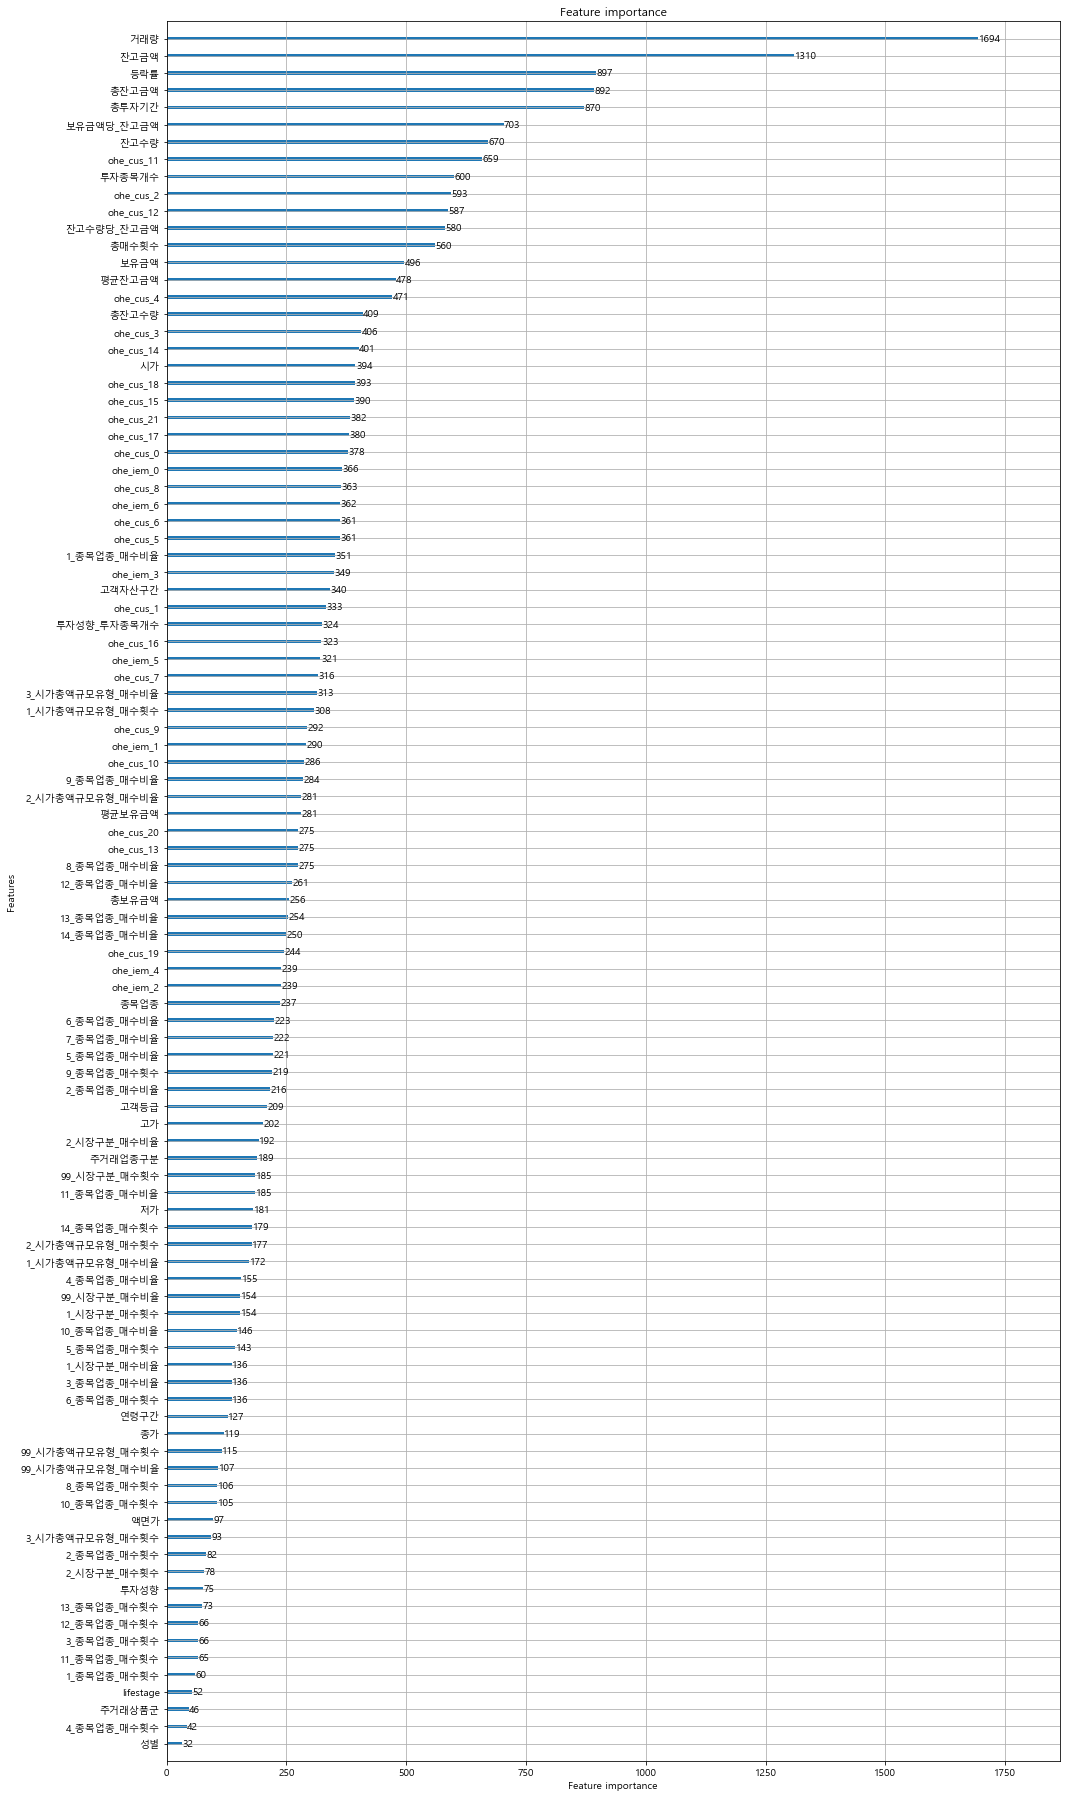

In [74]:
from lightgbm import plot_importance

plot_importance(clf, figsize=(16, 32), max_num_features=100)
plt.show()

In [75]:
importance_df = pd.DataFrame(data.columns)
importance_df['importance'] = clf.feature_importances_
importance_df.columns = ['feature_name','importance']
importance_df_sorted = importance_df.sort_values('importance', ascending = False)

In [76]:
importance_df_sorted.head(20)

,feature_name,importance
102,거래량,1694
1,잔고금액,1310
103,등락률,897
20,총잔고금액,892
10,총투자기간,870
26,보유금액당 잔고금액,703
0,잔고수량,670
80,ohe_cus_11,659
15,투자종목개수,600
71,ohe_cus_2,593


#### Feature Selection & Cross Validation

In [93]:
ftr = data
target = y_train
target_log = np.log1p(target)

In [94]:
from sklearn.feature_selection import SelectFromModel
smf = SelectFromModel(clf, threshold='1.0*mean')
smf.fit(ftr, target)
X_new = smf.transform(ftr)
X_te_new = smf.transform(data_te)
feature_idx = smf.get_support()
feature_name = ftr.columns[feature_idx]

In [95]:
print(ftr.columns[feature_idx])
print(len(ftr.columns[feature_idx]))

Index(['잔고수량', '잔고금액', '고객자산구간', '총투자기간', '투자종목개수', '투자성향_투자종목개수', '총매수횟수',
       '총잔고수량', '총잔고금액', '평균잔고금액', '잔고수량당 잔고금액', '보유금액', '총보유금액', '보유금액당 잔고금액',
       '1_종목업종 매수비율', '1_시가총액규모유형 매수횟수', '3_시가총액규모유형 매수비율', 'ohe_cus_0',
       'ohe_cus_1', 'ohe_cus_2', 'ohe_cus_3', 'ohe_cus_4', 'ohe_cus_5',
       'ohe_cus_6', 'ohe_cus_7', 'ohe_cus_8', 'ohe_cus_10', 'ohe_cus_11',
       'ohe_cus_12', 'ohe_cus_13', 'ohe_cus_14', 'ohe_cus_15', 'ohe_cus_16',
       'ohe_cus_17', 'ohe_cus_18', 'ohe_cus_19', 'ohe_cus_20', 'ohe_cus_21',
       'ohe_iem_0', 'ohe_iem_5', '시가', '거래량', '등락률'],
      dtype='object')
43


In [96]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X_new, target, scoring='neg_mean_squared_error', cv=5)
print('교차 검증별 MSE:', np.round(scores, 4))
print('평균 검증 MSE:', - np.round(np.mean(scores), 4))
print('RMSE:', np.sqrt(-np.mean(scores)))

# 0.5mean - 50.5257 : 77개
# 1.0mean - 50.4315 : 43개
# 1.5mean - 50.7184 : 16개

교차 검증별 MSE: [-4331.4971 -4261.5894 -2469.7291 -1109.5511  -544.3285]
평균 검증 MSE: 2543.339
RMSE: 50.431528036185384


In [101]:
feature_name

Index(['잔고수량', '잔고금액', '고객자산구간', '총투자기간', '투자종목개수', '투자성향_투자종목개수', '총매수횟수',
       '총잔고수량', '총잔고금액', '평균잔고금액', '잔고수량당 잔고금액', '보유금액', '총보유금액', '보유금액당 잔고금액',
       '1_종목업종 매수비율', '1_시가총액규모유형 매수횟수', '3_시가총액규모유형 매수비율', 'ohe_cus_0',
       'ohe_cus_1', 'ohe_cus_2', 'ohe_cus_3', 'ohe_cus_4', 'ohe_cus_5',
       'ohe_cus_6', 'ohe_cus_7', 'ohe_cus_8', 'ohe_cus_10', 'ohe_cus_11',
       'ohe_cus_12', 'ohe_cus_13', 'ohe_cus_14', 'ohe_cus_15', 'ohe_cus_16',
       'ohe_cus_17', 'ohe_cus_18', 'ohe_cus_19', 'ohe_cus_20', 'ohe_cus_21',
       'ohe_iem_0', 'ohe_iem_5', '시가', '거래량', '등락률'],
      dtype='object')

In [103]:
X_new = pd.DataFrame(X_new, columns = ftr.columns[feature_idx])
X_te_new = pd.DataFrame(X_te_new, columns = ftr.columns[feature_idx])

In [104]:
X_new.shape, X_te_new.shape

((681472, 43), (70596, 43))

### HP tuning

In [105]:
ftr = X_new
target = y_train
target_log = np.log1p(target)

In [106]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(ftr, target, test_size=0.2, random_state=0)
train_x.shape, valid_x.shape

((545177, 43), (136295, 43))

In [114]:
from bayes_opt import BayesianOptimization

bayesian_params = {
    'max_depth':(8, 16),
    'num_leaves':(24, 64),
    'min_child_samples':(10, 200),
    'min_child_weight':(1, 50),
    'subsample':(0.5, 1),
    'colsample_bytree':(0.5, 1),
    'max_bin':(10, 500),
    'reg_lambda':(0.001, 10),
    'reg_alpha':(0.01, 50)
}

In [115]:
def lgb_rmse_eval(max_depth, num_leaves, min_child_samples, min_child_weight, subsample, 
                colsample_bytree, max_bin, reg_lambda, reg_alpha):
    
    params = {
        "n_estimators":2000, 
        "learning_rate":0.02,
        'max_depth':int(round(max_depth)),
        'num_leaves':int(round(num_leaves)),
        'min_child_samples': int(round(min_child_samples)),
        'min_child_weight': int(round(min_child_weight)),
        'subsample':max(min(subsample, 1), 0),
        'colsample_bytree':max(min(colsample_bytree, 1), 0),
        'reg_lambda': max(reg_lambda,0),
        'reg_alpha': max(reg_alpha, 0)
    }
    
    lgb_model = LGBMRegressor(**params)
    lgb_model.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'RMSE', verbose= 100, 
                early_stopping_rounds= 100)
    valid_pred = lgb_model.predict(valid_x)
    RMSE = np.sqrt(mean_squared_error(valid_y, valid_pred))
    
    return RMSE

In [116]:
lgbBO = BayesianOptimization(f=lgb_rmse_eval, pbounds=bayesian_params, random_state=0)
lgbBO.maximize(init_points=10, n_iter=10)

|   iter    |  target   | colsam... |  max_bin  | max_depth | min_ch... | min_ch... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 48.1788	training's l2: 2321.19	valid_1's rmse: 48.5893	valid_1's l2: 2360.92
[200]	training's rmse: 47.2703	training's l2: 2234.48	valid_1's rmse: 47.9271	valid_1's l2: 2297.01
[300]	training's rmse: 46.7432	training's l2: 2184.92	valid_1's rmse: 47.601	valid_1's l2: 2265.85
[400]	training's rmse: 46.3503	training's l2: 2148.35	valid_1's rmse: 47.3991	valid_1's l2: 2246.68
[500]	training's rmse: 46.058	training's l2: 2121.34	valid_1's rmse: 47.2601	valid_1's l2: 2233.52
[600]	training's rmse: 45.8147	training's l2: 2098.98	valid_1's rmse: 47.1637	valid_1's l2: 2224.42
[700]	training's rmse: 45.6056	training's l2: 2079.88	valid_1's rmse: 47

In [117]:
lgbBO.res

[{'target': 46.603128490301934,
  'params': {'colsample_bytree': 0.7744067519636624,
   'max_bin': 360.44278952248555,
   'max_depth': 12.822107008573152,
   'min_child_samples': 113.52780476941041,
   'min_child_weight': 21.75908516760633,
   'num_leaves': 49.835764522666246,
   'reg_alpha': 21.884984691022,
   'reg_lambda': 8.917838234820016,
   'subsample': 0.9818313802505146}},
 {'target': 46.85153812445172,
  'params': {'colsample_bytree': 0.6917207594128889,
   'max_bin': 397.94526866050563,
   'max_depth': 12.231159358023236,
   'min_child_samples': 117.92846660784714,
   'min_child_weight': 46.35423527634039,
   'num_leaves': 26.841442327915477,
   'reg_alpha': 4.36559369208002,
   'reg_lambda': 0.20316375600581688,
   'subsample': 0.916309922773969}},
 {'target': 46.56986556858505,
  'params': {'colsample_bytree': 0.8890783754749252,
   'max_bin': 436.30595264094137,
   'max_depth': 15.828946737862111,
   'min_child_samples': 161.8401272011775,
   'min_child_weight': 23.612488

In [118]:
# dictionary에 있는 target값을 모두 추출
target_list = []
for result in lgbBO.res:
    target = result['target']
    target_list.append(target)
print(target_list)
# 가장 큰 target 값을 가지는 순번(index)를 추출
print('maximum target index:', np.argmin(np.array(target_list)))

[46.603128490301934, 46.85153812445172, 46.56986556858505, 46.64963303554705, 46.66615061206089, 46.64474590299299, 46.72564652485473, 46.57749507323836, 46.89373569837182, 46.657567723932125, 46.815330738610854, 46.92953055290316, 46.85730809652243, 47.008612673769306, 47.046774504230065, 46.95646056994563, 47.02982392217666, 46.82877822186521, 47.0540898315414, 46.89554295316334]
maximum target index: 2


In [119]:
# 가장 큰 target값을 가지는 index값을 기준으로 res에서 해당 parameter 추출. 
max_dict = lgbBO.res[np.argmin(np.array(target_list))]
print(max_dict)

{'target': 46.56986556858505, 'params': {'colsample_bytree': 0.8890783754749252, 'max_bin': 436.30595264094137, 'max_depth': 15.828946737862111, 'min_child_samples': 161.8401272011775, 'min_child_weight': 23.61248875039366, 'num_leaves': 55.22116705145822, 'reg_alpha': 5.922538549187972, 'reg_lambda': 6.3995702922539115, 'subsample': 0.5716766437045232}}


In [120]:
ftr = X_new
target = y_train
target_log = np.log1p(target)

In [121]:
from sklearn.model_selection import KFold

def train_apps_all_with_oof(ftr, target, nfolds=5):
    ftr = ftr
    target = target

    # nfolds 개의 cross validatin fold set을 가지는 KFold 생성 
    folds = KFold(n_splits=nfolds, shuffle=True, random_state=0)
    
    # Out of Folds로 학습된 모델의 validation set을 예측하여 결과 확률을 담을 array 생성.
    # validation set가 n_split갯수만큼 있으므로 크기는 ftr_app의 크기가 되어야 함. 
    oof_preds = np.zeros((ftr.shape[0],))  
    
    # Ouf of Folds로 학습된 모델의 test dataset을 예측하여 결과 확률을 담을 array 생성. 
    test_preds = np.zeros(((X_te_new.shape[0],)))
    
    # n_estimators를 4000까지 확대. 
    clf = LGBMRegressor(
                nthread=4,
                n_estimators=4000,
                learning_rate=0.01,
                max_depth=16,
                num_leaves=55,
                colsample_bytree=0.89,
                subsample=0.572,
                max_bin=436,
                reg_alpha=5.923,
                reg_lambda=6.400,
                min_child_weight=24,
                min_child_samples=162,
                silent=-1,
                verbose=-1,
                )

    # nfolds 번 cross validation Iteration 반복하면서 OOF 방식으로 학습 및 테스트 데이터 예측
    for fold_idx, (train_idx, valid_idx) in enumerate(folds.split(ftr)):
        print('##### iteration ', fold_idx, ' 시작')
        # 학습용 데이터 세트의 인덱스와 검증용 데이터 세트의 인덱스 추출하여 이를 기반으로 학습/검증 데이터 추출
        train_x = ftr.iloc[train_idx, :]
        train_y = target[train_idx]
        valid_x = ftr.iloc[valid_idx, :]
        valid_y = target[valid_idx]
        
        # 추출된 학습/검증 데이터 세트로 모델 학습. early_stopping은 200으로 증가. 
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'RMSE', verbose= 200, 
                early_stopping_rounds= 200)
        # 검증 데이터 세트로 예측된 확률 저장. 사용되지는 않음. 
        #oof_preds[valid_idx] = clf.predict(valid_x, num_iteration=clf.best_iteration_)       
        # 학습된 모델로 테스트 데이터 세트에 예측 확률 계산. 
        # nfolds 번 반복 실행하므로 평균 확률을 구하기 위해 개별 수행시 마다 수행 횟수로 나눈 확률을 추후에 더해서 최종 평균 확률 계산. 
        test_preds += clf.predict(X_te_new, num_iteration=clf.best_iteration_)/folds.n_splits
        
        
    return clf, test_preds

In [122]:
clf, test_preds = train_apps_all_with_oof(ftr, target, nfolds=5)

##### iteration  0  시작
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 48.0932	training's l2: 2312.95	valid_1's rmse: 48.5294	valid_1's l2: 2355.1
[400]	training's rmse: 47.1544	training's l2: 2223.54	valid_1's rmse: 47.8481	valid_1's l2: 2289.44
[600]	training's rmse: 46.6222	training's l2: 2173.63	valid_1's rmse: 47.5207	valid_1's l2: 2258.21
[800]	training's rmse: 46.2424	training's l2: 2138.36	valid_1's rmse: 47.3351	valid_1's l2: 2240.61
[1000]	training's rmse: 45.9505	training's l2: 2111.44	valid_1's rmse: 47.2	valid_1's l2: 2227.84
[1200]	training's rmse: 45.7095	training's l2: 2089.36	valid_1's rmse: 47.0992	valid_1's l2: 2218.33
[1400]	training's rmse: 45.4971	training's l2: 2069.99	valid_1's rmse: 47.0197	valid_1's l2: 2210.85
[1600]	training's rmse: 45.3038	training's l2: 2052.44	valid_1's rmse: 46.9425	valid_1's l2: 2203.6
[18

In [123]:
test_preds

array([130.30863997, 101.87477174, 128.7989717 , ...,  85.4118048 ,
       105.05766977,  94.88089992])

In [124]:
submission["hold_d"] = np.round(test_preds)

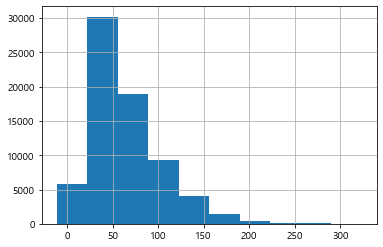

In [127]:
submission.hold_d.hist()
plt.show()

In [128]:
submission[submission.hold_d < 0]

,submit_id,hold_d
5843,IDX05844,-2.0
9374,IDX09375,-11.0
19784,IDX19785,-10.0
21767,IDX21768,-4.0
22153,IDX22154,-1.0
29454,IDX29455,-3.0
29890,IDX29891,-1.0
31893,IDX31894,-2.0
31894,IDX31895,-5.0
35195,IDX35196,-2.0


In [129]:
submission[submission.hold_d > 146]

,submit_id,hold_d
6,IDX00007,148.0
7,IDX00008,159.0
8,IDX00009,167.0
9,IDX00010,149.0
21,IDX00022,179.0
...,...,...
68384,IDX68385,150.0
68386,IDX68387,147.0
68683,IDX68684,153.0
69316,IDX69317,152.0


In [130]:
submission['hold_d'] = submission.hold_d.apply(lambda x: 0 if x<0 else x)
submission['hold_d'] = submission.hold_d.apply(lambda x: 146 if x>146 else x)

In [131]:
submission["hold_d"] = submission["hold_d"] + test.이전주식보유기간
submission

,submit_id,hold_d
0,IDX00001,283.0
1,IDX00002,437.0
2,IDX00003,268.0
3,IDX00004,336.0
4,IDX00005,124.0
...,...,...
70591,IDX70592,85.0
70592,IDX70593,223.0
70593,IDX70594,943.0
70594,IDX70595,116.0


### 결과물 저장

In [132]:
submission.to_csv('kyu_6_sk.csv', index = False)